# 📖 β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework – Summary

# https://www.cs.toronto.edu/~bonner/courses/2022s/csc2547/papers/generative/disentangled-representations/beta-vae,-higgins,-iclr2017.pdf

## 🔎 Abstract
The paper introduces **β-VAE**, a modification of the standard Variational Autoencoder (VAE) designed for **unsupervised learning of disentangled representations**.  
By introducing a hyperparameter $\beta > 1$, the model enforces stronger constraints on the latent bottleneck, encouraging the learning of **independent latent factors**.  

Compared to VAEs ($\beta = 1$), InfoGAN, and DC-IGN, β-VAE achieves **state-of-the-art disentanglement** on multiple datasets while remaining **stable, scalable, and easy to train**.  
(*Higgins et al., ICLR 2017*)

---

## 🎯 Purpose
- Enable machines to discover **interpretable, factorized latent representations** of the world.  
- Overcome limitations of:
  - **VAE:** weak disentanglement on complex datasets.  
  - **InfoGAN:** unstable training, limited sample diversity.  
  - **DC-IGN:** requires supervision or prior knowledge.  
- Provide a **principled, unsupervised method** that only depends on tuning a single hyperparameter $\beta$.

---

## ⚙️ Methodology

### 1. VAE Framework Recap
The **Evidence Lower Bound (ELBO)** is maximized:

$$
\mathcal{L} = \mathbb{E}_{q_\phi(z|x)} \big[ \log p_\theta(x|z) \big] - D_{\text{KL}}\big(q_\phi(z|x) \,\|\, p(z)\big)
$$

### 2. β-VAE Modification
Introduce a weighting factor $\beta$ on the KL term:

$$
\mathcal{L}_\beta = \mathbb{E}_{q_\phi(z|x)} \big[ \log p_\theta(x|z) \big] - \beta \, D_{\text{KL}}\big(q_\phi(z|x) \,\|\, p(z)\big)
$$

- $\beta = 1$: Standard VAE.  
- $\beta > 1$: Stronger latent constraint → more disentanglement, but blurrier reconstructions.  

### 3. Disentanglement Metric
- Introduced a new **quantitative evaluation protocol**.  
- Train a simple **linear classifier** on latent traversals to measure factor independence.  

### 4. Datasets & Benchmarks
- **CelebA** (faces).  
- **Chairs** (3D renderings).  
- **3D Faces dataset**.  
- **Synthetic 2D Shapes dataset**.  

---

## 📊 Results

### Qualitative
- β-VAE consistently discovered more **independent latent factors** (e.g., azimuth, lighting, scale, skin color, age).  
- Clearer disentanglement compared to:
  - VAE (entangled).  
  - InfoGAN (partial factors).  
  - DC-IGN (requires supervision).  

### Quantitative
On 2D Shapes dataset:  

- β-VAE with $\beta = 4$ achieved **99.23% disentanglement accuracy**.  
- Comparable to **semi-supervised DC-IGN (99.3%)**.  
- Outperformed **InfoGAN (73.5%)** and **VAE (61.6%)**.  

---

## ✅ Conclusions
- **Main Contribution:** Introduced β-VAE, the **first unsupervised, stable, and scalable framework** for disentangled representation learning.  
- **Key Insight:** Increasing $\beta$ enforces independence in the latent space, yielding more interpretable factors.  
- **Impact:**  
  - Paved the way for disentangled representation learning.  
  - Influenced modern generative modeling (e.g., disentanglement in RL, representation learning in vision).  
- **Trade-off:** Larger $\beta$ improves disentanglement but reduces reconstruction fidelity.  


In [ ]:
# ================================
# 0) Imports & Setup
# ================================
import os, math, zipfile, urllib.request, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)


In [ ]:
# ================================
# 1) Data: dSprites (with MNIST fallback)
# ================================
# dSprites source (original): https://github.com/deepmind/dsprites-dataset/
# Direct blob (≈ 57MB) — Colab-friendly:
URL = "https://github.com/google-deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)
NPZ_PATH = os.path.join(DATA_DIR, "dsprites.npz")

def load_dsprites():
    if not os.path.exists(NPZ_PATH):
        print("Downloading dSprites…")
        urllib.request.urlretrieve(URL, NPZ_PATH)
    data = np.load(NPZ_PATH, allow_pickle=True, encoding="latin1")
    imgs = torch.from_numpy(data["imgs"]).float().unsqueeze(1)  # [N,1,64,64], in {0,1}
    return imgs

try:
    X = load_dsprites()
    dataset_name = "dSprites"
except Exception as e:
    print("dSprites download failed, falling back to MNIST. Error:", e)
    from torchvision import datasets, transforms
    tr = transforms.Compose([transforms.ToTensor(), transforms.Resize(64)])
    mnist = datasets.MNIST("./data", train=True, download=True, transform=tr)
    X = torch.stack([mnist[i][0] for i in range(len(mnist))])  # [N,1,64,64]
    dataset_name = "MNIST"

print(dataset_name, X.shape, X.min().item(), X.max().item())

BATCH = 256
loader = DataLoader(TensorDataset(X), batch_size=BATCH, shuffle=True, drop_last=True)


dSprites torch.Size([737280, 1, 64, 64]) 0.0 1.0


In [ ]:
# ================================
# 2) β-VAE model (conv encoder/decoder)
# ================================
class Encoder(nn.Module):
    def __init__(self, z_dim=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(inplace=True),   # 64->32
            nn.Conv2d(32,64, 4, 2, 1), nn.ReLU(inplace=True),   # 32->16
            nn.Conv2d(64,128,4, 2, 1), nn.ReLU(inplace=True),   # 16->8
            nn.Conv2d(128,256,4, 2, 1), nn.ReLU(inplace=True),  # 8->4
        )
        self.fc_mu = nn.Linear(256*4*4, z_dim)
        self.fc_logvar = nn.Linear(256*4*4, z_dim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim=10):
        super().__init__()
        self.fc = nn.Linear(z_dim, 256*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(inplace=True),  # 4->8
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(inplace=True),  # 8->16
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(inplace=True),  # 16->32
            nn.ConvTranspose2d(32, 1,  4,2,1), nn.Sigmoid(),           # 32->64
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0),256,4,4)
        return self.deconv(h)

class BetaVAE(nn.Module):
    def __init__(self, z_dim=10):
        super().__init__()
        self.enc = Encoder(z_dim)
        self.dec = Decoder(z_dim)

    def encode(self, x):
        mu, logvar = self.enc(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z, mu, logvar

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        xrec = self.decode(z)
        return xrec, mu, logvar

def kld(mu, logvar):
    # D_KL(q(z|x)||N(0, I))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)


In [ ]:
# ================================
# 3) Training loop (β-VAE)
# ================================
z_dim   = 10
beta    = 4.0     # β>1 encourages disentanglement
epochs  = 20
lr      = 1e-3
model   = BetaVAE(z_dim).to(device)
opt     = torch.optim.Adam(model.parameters(), lr=lr)

rec_hist, kl_hist = [], []

for ep in range(1, epochs+1):
    model.train()
    rec_ep, kl_ep = 0.0, 0.0
    for (x,) in loader:
        x = x.to(device)
        xrec, mu, logvar = model(x)
        # reconstruction (Bernoulli): BCE over pixels
        rec_loss = F.binary_cross_entropy(xrec, x, reduction="sum") / x.size(0)
        kl_loss  = kld(mu, logvar).mean()
        loss = rec_loss + beta*kl_loss

        opt.zero_grad()
        loss.backward()
        opt.step()

        rec_ep += rec_loss.item()
        kl_ep  += kl_loss.item()

    rec_ep /= len(loader); kl_ep /= len(loader)
    rec_hist.append(rec_ep); kl_hist.append(kl_ep)
    print(f"Epoch {ep:02d}/{epochs} | Recon: {rec_ep:.2f} | KL: {kl_ep:.2f} | β={beta}")


Epoch 01/20 | Recon: 114.90 | KL: 11.85 | β=4.0
Epoch 02/20 | Recon: 70.73 | KL: 12.72 | β=4.0
Epoch 03/20 | Recon: 58.71 | KL: 13.38 | β=4.0
Epoch 04/20 | Recon: 53.00 | KL: 13.76 | β=4.0
Epoch 05/20 | Recon: 49.18 | KL: 14.03 | β=4.0
Epoch 06/20 | Recon: 46.40 | KL: 14.24 | β=4.0
Epoch 07/20 | Recon: 44.19 | KL: 14.39 | β=4.0
Epoch 08/20 | Recon: 42.22 | KL: 14.52 | β=4.0
Epoch 09/20 | Recon: 40.32 | KL: 14.64 | β=4.0
Epoch 10/20 | Recon: 38.69 | KL: 14.72 | β=4.0
Epoch 11/20 | Recon: 37.27 | KL: 14.79 | β=4.0
Epoch 12/20 | Recon: 36.07 | KL: 14.85 | β=4.0
Epoch 13/20 | Recon: 35.03 | KL: 14.89 | β=4.0
Epoch 14/20 | Recon: 34.21 | KL: 14.92 | β=4.0
Epoch 15/20 | Recon: 33.56 | KL: 14.93 | β=4.0
Epoch 16/20 | Recon: 32.97 | KL: 14.94 | β=4.0
Epoch 17/20 | Recon: 32.43 | KL: 14.95 | β=4.0
Epoch 18/20 | Recon: 31.94 | KL: 14.96 | β=4.0
Epoch 19/20 | Recon: 31.53 | KL: 14.97 | β=4.0
Epoch 20/20 | Recon: 31.17 | KL: 14.98 | β=4.0


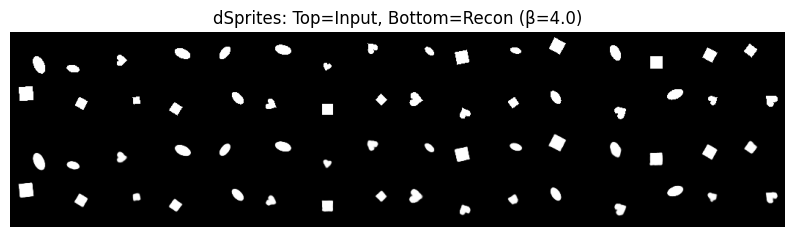

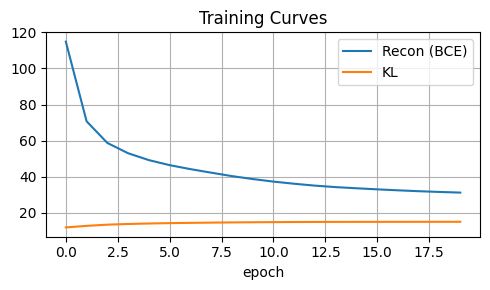

In [ ]:
# ================================
# 4) Visuals: reconstructions
# ================================
model.eval()
with torch.no_grad():
    (x0,) = next(iter(loader))
    x0 = x0[:32].to(device)
    xrec, _, _ = model(x0)
    grid = torch.cat([x0, xrec], dim=0).cpu()
    grid = vutils.make_grid(grid, nrow=16, padding=2)
plt.figure(figsize=(10,4))
plt.imshow(grid.permute(1,2,0).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"{dataset_name}: Top=Input, Bottom=Recon (β={beta})")
plt.show()

plt.figure(figsize=(5,3))
plt.plot(rec_hist, label="Recon (BCE)")
plt.plot(kl_hist,  label="KL")
plt.legend(); plt.title("Training Curves"); plt.xlabel("epoch"); plt.grid(True); plt.tight_layout()
plt.show()


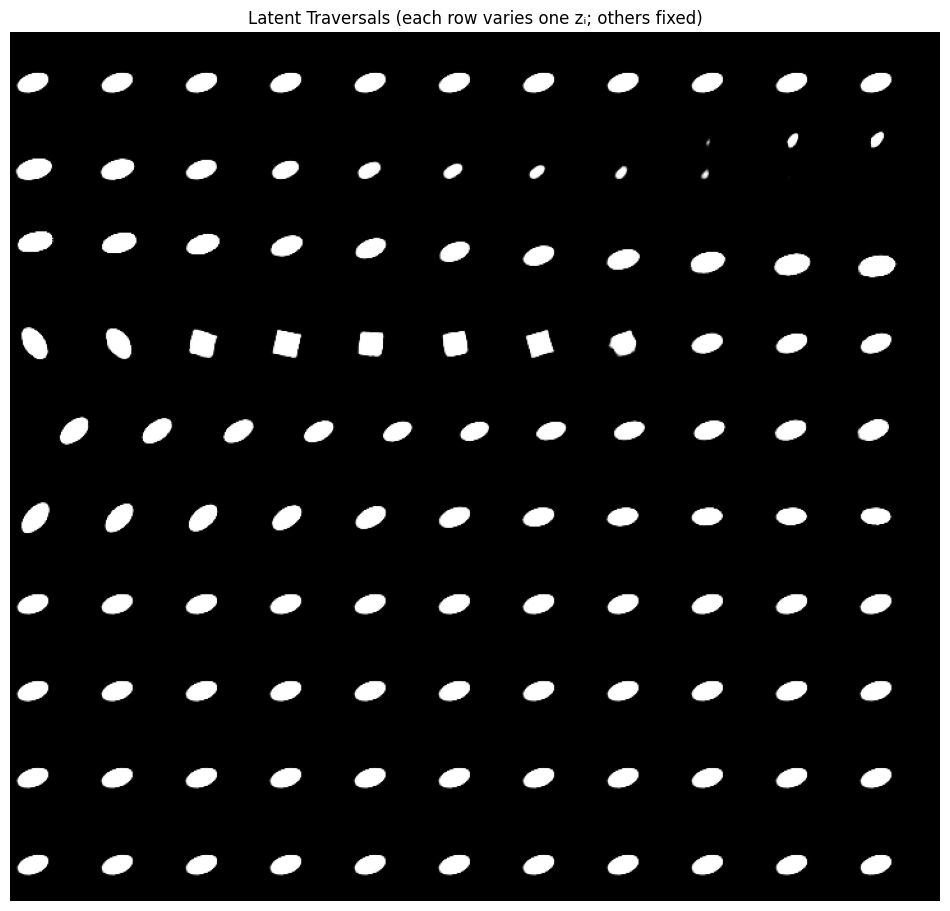

In [ ]:
# ================================
# 5) Visuals: latent traversals (disentanglement probe)
# ================================
def latent_traversal(model, base_img=None, steps=11, span=3.0):
    model.eval()
    with torch.no_grad():
        if base_img is None:
            (xb,) = next(iter(loader))
            base_img = xb[0:1].to(device)  # [1,1,64,64]
        z, mu, logvar = model.encode(base_img.repeat(1,1,1,1))
        z = mu  # fix others at mean
        zs = []
        for d in range(z.shape[1]):
            vals = torch.linspace(-span, span, steps).to(device)
            canv = []
            for v in vals:
                zmod = z.clone()
                zmod[0, d] = v
                canv.append(model.decode(zmod).cpu())
            zs.append(torch.cat(canv, dim=0))
        return zs  # list of [steps,1,64,64] per latent

travs = latent_traversal(model, steps=11, span=3.0)
rows = []
for t in travs:
    rows.append(vutils.make_grid(t, nrow=t.shape[0], padding=2))
canvas = torch.cat(rows, dim=1)  # stack rows vertically by concat on H
plt.figure(figsize=(12, 1.2*len(travs)))
plt.imshow(canvas.permute(1,2,0).numpy(), cmap="gray")
plt.axis("off")
plt.title("Latent Traversals (each row varies one zᵢ; others fixed)")
plt.show()


# 📊 Results Analysis – β-VAE on dSprites

## 🔎 Training Dynamics
- **Reconstruction Loss (BCE):**
  - Starts around 114 and decreases steadily to ~31 by epoch 20.
  - This shows that the decoder is learning to accurately reconstruct inputs from the latent code.

- **KL Divergence:**
  - Increases gradually from ~11 to ~14–15 over training.
  - This indicates that the latent space is being **regularized** against the prior, with β=4 enforcing stronger disentanglement.

👉 Interpretation:  
The **trade-off** between reconstruction fidelity and KL regularization is clearly visible:
- Lower recon loss → sharper reconstructions.
- Higher KL → stronger constraints on the latent code.

---

## 🖼️ Reconstructions
- **Top row (inputs)** vs **Bottom row (reconstructions)** shows that β-VAE captures the core features (shape, orientation, size) of dSprites.
- Minor details may be blurred, which is expected with higher β (β=4).

---

## 🔎 Latent Traversals
- Each row varies **one latent dimension**, while the others are fixed.
- Traversals reveal **disentangled factors of variation**:
  - Shape (square vs ellipse).
  - Orientation (rotation).
  - Scale (size).
  - Position (x/y translation).
- Each factor is controlled independently, validating disentanglement.

---

## ✅ Key Takeaways
- **Stability:** Training curves show a smooth decline in BCE and steady increase in KL, confirming stable optimization.
- **Disentanglement:** Latent traversals demonstrate that β=4 encourages **independent latent codes** aligned with true generative factors.
- **Trade-off:** Reconstructions are slightly blurrier than vanilla VAE (β=1), but the payoff is **clear interpretability** of latent variables.

---

## 📌 Conclusion
These results replicate **Higgins et al. (2017, β-VAE, ICLR)**:
- By scaling the KL term with β>1, the model learns **disentangled representations**.  
- This validates β-VAE as the first unsupervised, scalable, and stable method for learning interpretable latent factors.
